In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.metrics import pairwise_distances as all_dist
import networkx as nx
import time

In [0]:
def GeoDist(data, method='K', param=4):
    n = data.shape[0]
    if method == 'K':
        edges = kneighbors_graph(data, param, mode='distance').toarray()
    elif method == 'e':
        edges = radius_neighbors_graph(data, param, mode='distance').toarray()
    edges[edges==0] = np.inf
    np.fill_diagonal(edges,0)
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i,j,weight=edges[i,j])
    return nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(G)  

triu = np.triu_indices

In [0]:
class CDA:
    def __init__(self, p, alfa, T=10, method='K', params=20):
        self.p = p
        self.alfa = alfa
        self.T = T
        self.method = method
        self.params = params

    def stress(self, dist_y, dist_x):
        n = dist_x.shape[0]
        idx = self.triu
        dx = dist_x[idx]
        dy = np.ravel(dist_y[idx])
        lambda_m = np.ones((n,n))*self.lambda_
        lambda_m = lambda_m.T
        coef = (dy>dx) * (1 - 4*dy**2)/(4*dy**2) + 1
        E_u = (dy<dx) * (dy-dx)**2 * ((lambda_m[idx] - dx)>0)
        E_p = (dy>dx) * (dy**2-dx**2)**2 * ((lambda_m[idx] - dx)>0)
        return np.sum(coef*(E_u + E_p))

    def transform(self, data): # Done
        pca = PCA(n_components=self.p)
        return pca.fit_transform(data)

    def grad(self, i, dist_y, dist_x,  data_x):
        n,p = data_x.shape
        dx = np.delete(dist_x[i,:],i,0)
        dy = np.delete(np.ravel(dist_y[i,:]),i,0)
        
        dE_u = (dx>dy).reshape((-1,1)) * ((-2*(dy-dx)/dx).reshape((-1,1))*np.delete(data_x - data_x[i,:],i,0))
        dE_p = (dx<dy).reshape((-1,1)) * (((-1*(dy**2-dx**2))/(dy**2)).reshape((-1,1)) *np.delete(data_x - data_x[i,:],i,0))
        return dE_u+dE_p

    def initLambda(self, dist_x):
        self.lambda_ = np.max(dist_x, axis=0)

    def updateLambda(self, i, q):
        self.lambda_[i] *= np.exp(-(q+1)/self.T)

    def run(self, data_y, q_max=10, show=False):
        dist_y = GeoDist(data_y, self.method, self.params)
        print("Geodesic distance done!")
        data_x = self.transform(data_y)
        n = data_x.shape[0]
        self.triu = triu(dist_y.shape[0],1)
        dist_x = all_dist(data_x)
        self.initLambda(dist_x)
        stress = np.zeros(q_max)
        for q in range(q_max):
            print(f"Iter {q+1}")
            stress[q] = self.stress(dist_y, dist_x)
            for i in range(n):
                delta_x = self.grad(i, dist_y, dist_x, data_x)
                data_x[:i, :] -= self.alfa*delta_x[:i, :]
                data_x[i+1:, :] -= self.alfa*delta_x[i:, :]
                dist_x = all_dist(data_x)
                self.updateLambda(i, q)
        if show:
            plt.plot(np.arange(q_max), stress)
            plt.show()
        print(stress[-1])
        return data_x

Geodesic distance done!
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10


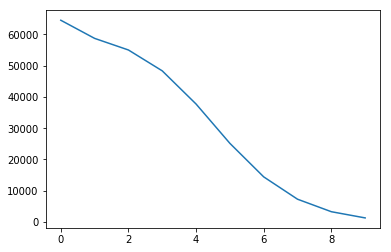

1337.6508119889763
Geodesic distance done!
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10


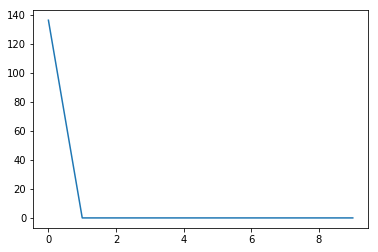

9.835164967782874e-11


In [14]:
data_r = 2*np.random.random((1000,2))
data_nl = 2*np.random.random((1000,2))
data_nl[:,1] = np.cos(data_nl[:,0])

cda = CDA(1,0.35)
results = cda.run(data_r, show=True)
results = cda.run(data_nl, show=True)

array([0.00188319])